# Churchland Widefield Data

This notebook demonstrates:
- Decoding L/R choice from different periods of the delay period

In [2]:
# Import statements
import numpy as np
import pandas as pd
import ssm
import seaborn as sns
import numpy.random as npr
import matplotlib.pyplot as plt
import numpy.linalg as la
from collections import OrderedDict
from matplotlib.font_manager import FontProperties
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import Axes3D
from scipy.io import loadmat
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from ssm import LDS
from Session import *
from LVM import *
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

In [3]:
from matplotlib.cm import get_cmap
cmap = get_cmap('coolwarm')

## 1A. Load data and BehaveNet reconstructions for the best model

In [4]:
def undo_zscore(neural, predictions):
    """
    Assumes data is trial x time x components
    
    Args:
        neural: original neural activity
        predictions: predicted z-scored activity
    Returns:
        predictions with the z-scoring undone
    """

    predictions = predictions.copy()
    predictions *= np.std(neural, axis=(0,1))
    predictions += np.mean(neural, axis=(0,1))
    return predictions

def zscore(data):
    """
    Assumes data is trial x time x components
    """

    data -= np.mean(data, axis=(0,1))
    data /= np.std(data, axis=(0,1))
    return data

In [5]:
session = Session("vistrained", "mSM30", "10-Oct-2017")
all_neural_data = session.neural['neural']
delay_period_indices = session.get_delay_period(include_stim=True)
excerpt_indices = []
for trial in range(delay_period_indices.shape[0]):
    start = delay_period_indices[trial,:][0] - 30
    end = delay_period_indices[trial,:][0] + 90
    excerpt_indices.append([start, end])
trial_choices = session.trialmarkers['ResponseSide']

In [6]:
bn_version = 'version_223'
ffdatadir = "/home/chingf/Code/Widefield/analysis/musall/vistrained/mSM30/10-Oct-2017/ae-neural/16_latents/ff/all/test/"
predictions_file = ffdatadir + bn_version + "/" + "predictions.pkl"
with open(predictions_file, "rb") as f:
    predictions_data = pickle.load(f)
predictions = np.nan_to_num(
    predictions_data['predictions']
    )
scaled_predictions = undo_zscore(all_neural_data, predictions)
predictions_trials = predictions_data['trials']

In [7]:
# Extract bins of interest
predictions_excerpt = []
neural_data_excerpt = []
for trial in range(scaled_predictions.shape[0]):
    activity = scaled_predictions[trial,:,:]
    indices = excerpt_indices[trial]
    predictions_excerpt.append(activity[indices[0]:indices[1],:])
    neural_data_excerpt.append(
        all_neural_data[trial,indices[0]:indices[1],:]
        )
scaled_predictions = np.array(predictions_excerpt)
neural_data_excerpt = np.array(neural_data_excerpt)

## 1B. Fit logistic regression models over each time step
### Features: flattened neural activity

In [30]:
def fit_LR(start_idx, window_length):
    """
    Fits a L2-regularized logistic regression model, predicting
    left/right licking choice.
    
    Args
        start_idx: index in delay period to start extracting a window
            of activity.
        window_length: size of the window of activity to extract
    """
    
    X = []
    y = []
    # Extracting training and test data
    for trial in range(trial_choices.size):
        choice = trial_choices[trial]
        if np.isnan(choice):
            continue
        activity = scaled_predictions[trial,start_idx:start_idx+window_length,:]
        X.append(activity.flatten())
        y.append(int(choice-1))
    X = np.array(X)
    y = np.array(y)
    
    # Training the model with cross validation
    log_reg = LogisticRegressionCV(
        Cs=5, cv=5, scoring='accuracy', max_iter=500
        )
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    log_reg.fit(X, y)
    return log_reg

In [34]:
# Do a grid search over start index and window length
# Fit logistic regression models
window_length = 2
results = []

start_idxs = range(0, 120, 2)
for start_idx in start_idxs:
    log_reg = fit_LR(start_idx, window_length)
    results.append(log_reg)

/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

In [40]:
# Save the logistic regression models
pickle.dump(results, open("temporaldecoding_reconstructions.p", "wb" ) )

## 2. Decoding: Which time periods are most predictive?
### Features: flattened neural activity

In [8]:
# Extract the results corresponding to window_size = 2
with open("temporaldecoding_reconstructions.p", "rb") as f:
    results = pickle.load(f)

In [9]:
reg_indxs = session.neural['reg_indxs_consolidate'].item()
reg_names = session.neural['reg_indxs_consolidate'].dtype.names

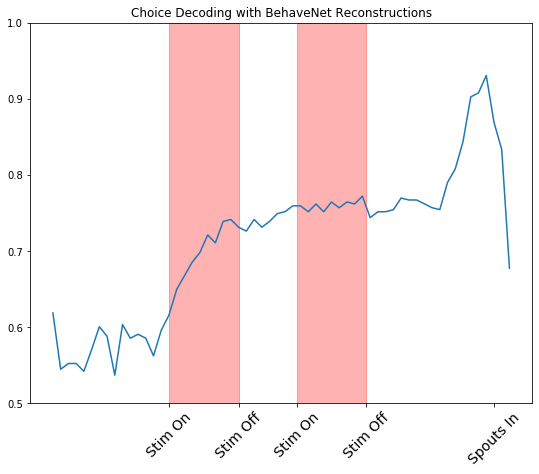

In [10]:
# Plot decoding accuracy over time
start_frame = []
accuracy = []
plt.figure(figsize=(9,7))
for frame, log_reg in enumerate(results):
    if log_reg == None:
        continue
    start_frame.append(frame*2)
    accuracy.append(
        np.max(np.mean(log_reg.scores_[1], axis=0))
        )
plt.xticks(
    ticks=[30, 30+18, 30+33, 30+51, 30+84],
    labels=['Stim On', 'Stim Off', 'Stim On', 'Stim Off', 'Spouts In'],
    rotation=45, fontsize=14
    )
plt.axvspan(30, 30+18, alpha=0.3, color='red')
plt.axvspan(30+33, 30+51, alpha=0.3, color='red')
plt.title("Choice Decoding with BehaveNet Reconstructions")
plt.ylim((0.5,1))
sns.lineplot(x=start_frame, y=accuracy)

## 3. Decoding: Which regions are most predictive?
### Using window frames of length 2 frames

In [11]:
# Collect coefficient values
coef_values_df = {}
coef_values_df['Trial Event'] = []
coef_values_df['Coefficients'] = []
coef_values_df['Brain Region'] = []
frames = [14/2, 40/2, 56/2, 72/2, 90/2]
events = ['Pre-Stim', 'Stim 1', 'Between Stims', 'Stim 2', 'Delay']

# Iterate over each region
session = Session("vistrained", "mSM30", "10-Oct-2017", access_engram=False, load_behavenet=False)
reg_indxs = session.neural['reg_indxs_consolidate'].item()
reg_names = session.neural['reg_indxs_consolidate'].dtype.names
for idx, reg_name in enumerate(reg_names):
    components = reg_indxs[idx].squeeze()

    # For each component in a region
    for component in components:
        # For each time step, collect the relevant coefficient values
        for idx, log_reg in enumerate(results):
            if idx not in frames:
                continue
            normalized_coefs = normalize(log_reg.coef_).squeeze()
            coef_values_df['Trial Event'].append(events[frames.index(idx)])
            coef_values_df['Coefficients'].append(
                np.abs(normalized_coefs[component-1]) # Components is 1-indexed!
                )
            coef_values_df['Brain Region'].append(reg_name)
coef_values_df = pd.DataFrame(data=coef_values_df)

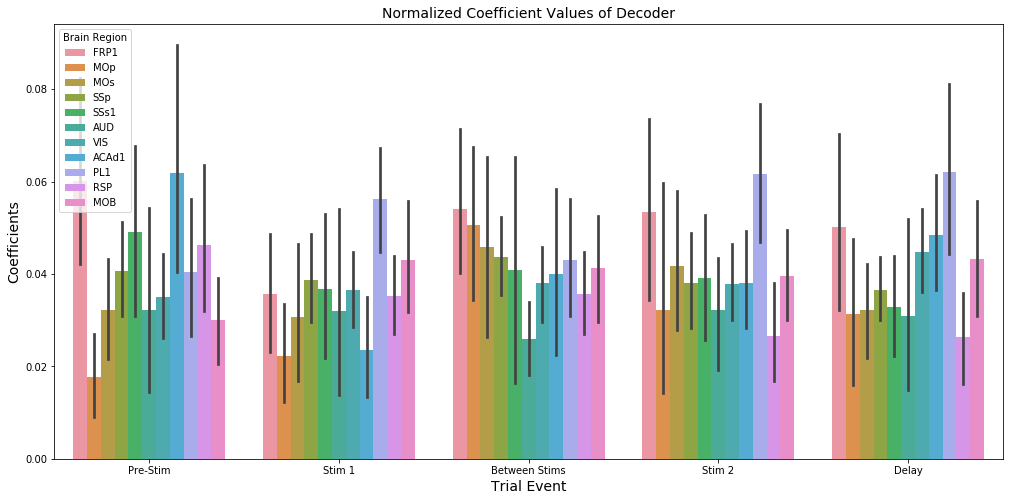

In [12]:
plt.figure(figsize=(17,8))
plt.title("Normalized Coefficient Values of Decoder", fontsize=14)
plt.ylabel("Value", fontsize=14)
plt.xlabel("Trial Event", fontsize=14)
ax = sns.barplot(
    x="Trial Event", y="Coefficients", hue="Brain Region", data=coef_values_df
    )

## 4. Which regions are reconstructed best?

In [13]:
scaled_predictions.shape

(393, 120, 200)

In [14]:
session = Session("vistrained", "mSM30", "10-Oct-2017", access_engram=False, load_behavenet=False)
reg_indxs = session.neural['reg_indxs_consolidate'].item()
reg_names = session.neural['reg_indxs_consolidate'].dtype.names

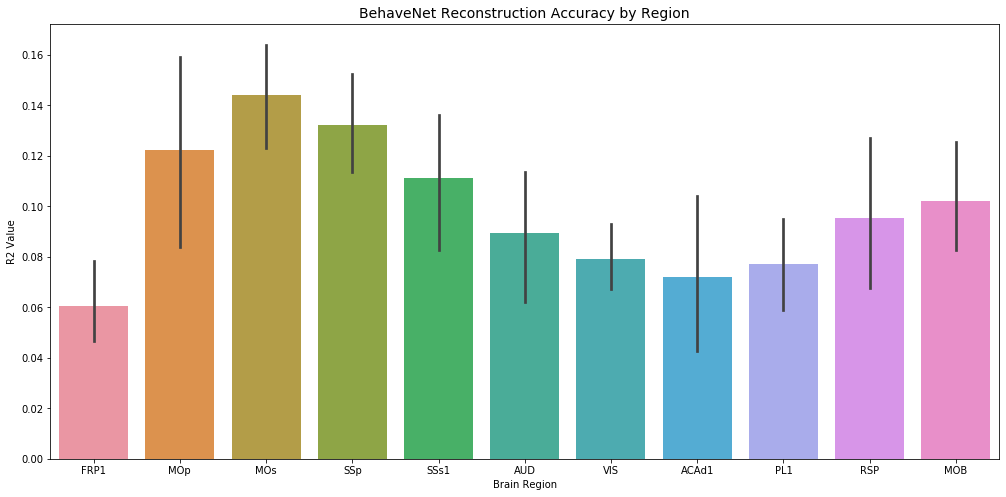

In [16]:
# Over the whole trial:
r2_df = {}
r2_df['R2 Value'] = []
r2_df['Brain Region'] = []

for idx, reg_name in enumerate(reg_names):
    components = reg_indxs[idx].squeeze()

    # For each component in a region
    for component in components:
        pred_activity = scaled_predictions[:,:,component-1]
        exp_activity = neural_data_excerpt[:,:,component-1]
        r2 = r2_score(exp_activity, pred_activity)
        r2_df['Brain Region'].append(reg_name)
        r2_df['R2 Value'].append(r2)
r2_df = pd.DataFrame(data=r2_df)

plt.figure(figsize=(17,8))
plt.title("BehaveNet Reconstruction Accuracy by Region", fontsize=14)
ax = sns.barplot(
    y="R2 Value", x="Brain Region", data=r2_df
    )

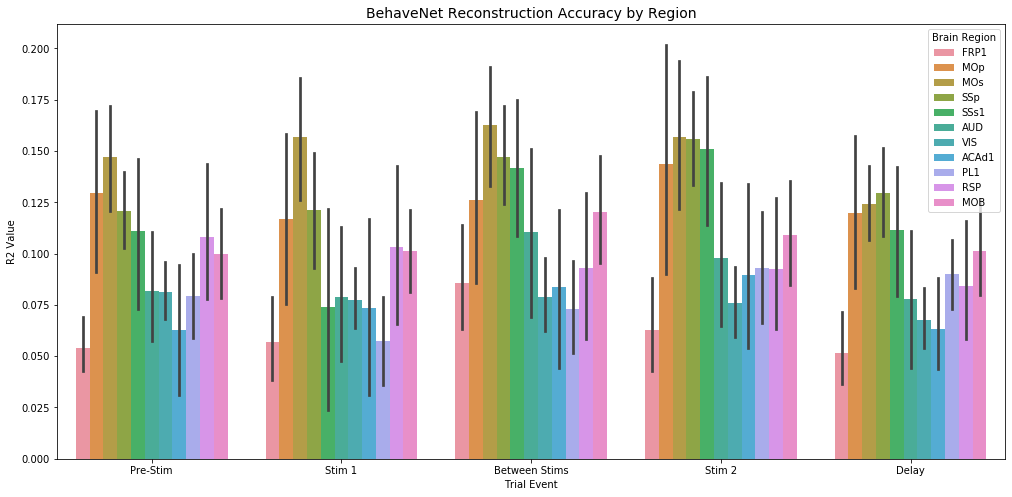

In [25]:
# Over different points of the trial
# Collect coefficient values
r2_df = {}
r2_df['Trial Event'] = []
r2_df['R2 Value'] = []
r2_df['Brain Region'] = []
frames = [[11, 28], [30,47], [49,66], [66,83], [84,101]]
events = ['Pre-Stim', 'Stim 1', 'Between Stims', 'Stim 2', 'Delay']

for idx, reg_name in enumerate(reg_names): 
    components = reg_indxs[idx].squeeze()

    # For each component in a region
    for component in components:
        
        for idx, frame in enumerate(frames):
            start_frame = frame[0]
            end_frame = frame[1]
            pred_activity = scaled_predictions[:,start_frame:end_frame,component-1]
            exp_activity = neural_data_excerpt[:,start_frame:end_frame,component-1]
            r2 = r2_score(exp_activity, pred_activity)
            r2_df['Brain Region'].append(reg_name)
            r2_df['R2 Value'].append(r2)
            r2_df['Trial Event'].append(events[idx])
r2_df = pd.DataFrame(data=r2_df)

plt.figure(figsize=(17,8))
plt.title("BehaveNet Reconstruction Accuracy by Region", fontsize=14)
ax = sns.barplot(
    y="R2 Value", x="Trial Event", hue="Brain Region", data=r2_df
    )